In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import plotly.graph_objs as go
from plotly.offline import iplot
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

pd.set_option('max_colwidth', None)

### Import CSV files obtained via NYtimes API.

In [135]:
df_full = pd.read_csv('extra_data/2023-1.csv', index_col=0)

# combine all months data into one big file 
for i in range(2,13):
    df = pd.read_csv(f'extra_data/2023-{i}.csv', index_col=0)
    df_full = pd.concat([df_full,df])

In [136]:
df_full.shape

(46043, 7)

In [137]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46043 entries, 0 to 3524
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   abstract          45713 non-null  object
 1   pub_date          46043 non-null  object
 2   document_type     46043 non-null  object
 3   news_desk         45044 non-null  object
 4   section_name      45718 non-null  object
 5   type_of_material  43687 non-null  object
 6   keywords          46043 non-null  object
dtypes: object(7)
memory usage: 2.8+ MB


In [138]:
df_full.head()

,abstract,pub_date,document_type,news_desk,section_name,type_of_material,keywords
0,"Underlying the debate in America over abortion is a big, difficult question.",2023-01-01T00:05:59+0000,article,National,U.S.,News,"['ABORTION', 'INTERNAL-OPEN-ACCESS']"
1,"The question is at the heart of the human experience — and the nation’s abortion debate. An exploration through science, theology and philosophy.",2023-01-01T00:15:57+0000,multimedia,U.S.,U.S.,Interactive Feature,"['PREGNANCY AND CHILDBIRTH', 'EMBRYOS (HUMAN)', 'BIOLOGY AND BIOCHEMISTRY', 'ANATOMY AND PHYSIOLOGY', 'RELIGION AND BELIEF', 'ABORTION', 'UNITED STATES', 'PHILOSOPHY', 'INTERNAL-SUB-ONLY']"
2,"Texas Christian returned two interceptions for touchdowns, just part of a zany back-and-forth upset of Michigan, 51-45, which put the Horned Frogs in the national championship game.",2023-01-01T01:27:54+0000,article,Sports,Sports,News,"['FOOTBALL (COLLEGE)', 'BIG 12 CONFERENCE', 'BIG TEN CONFERENCE', 'UNIVERSITY OF MICHIGAN', 'TEXAS CHRISTIAN UNIVERSITY', 'DYKES, DANIEL (SONNY) (1969- )', 'DUGGAN, MAX (2001- )', 'HARBAUGH, JIM']"
3,"Hours before Russian troops began withdrawing from the suburban town, a Russian soldier left a trail of blood and devastated lives in a last paroxysm of violence.",2023-01-01T04:00:10+0000,article,Foreign,World,News,"['BUCHA (UKRAINE)', 'WAR CRIMES, GENOCIDE AND CRIMES AGAINST HUMANITY', 'CIVILIAN CASUALTIES', 'RUSSIAN INVASION OF UKRAINE (2022)', 'DEFENSE AND MILITARY FORCES', 'PUTIN, VLADIMIR V', 'KYIV (UKRAINE)', 'RUSSIA']"
4,"Georgia scored in the final minute of the game, and Ohio State missed a field goal in the first minute of 2023.",2023-01-01T05:06:06+0000,article,Sports,Sports,News,"['FOOTBALL (COLLEGE)', 'COLLEGE FOOTBALL PLAYOFF NATIONAL CHAMPIONSHIP', 'PLAYOFF GAMES', 'PEACH BOWL (FOOTBALL GAME)', 'UNIVERSITY OF GEORGIA', 'OHIO STATE UNIVERSITY', 'BENNETT, STETSON (1997- )', 'STROUD, C J (2001- )', 'SMART, KIRBY', 'DAY, RYAN (1979- )']"


### data cleaning

#### fix data types

In [139]:
df_full['pub_date'] = pd.to_datetime(df_full['pub_date'])

#### remove brackets in `keywords`

In [140]:
def remove_brackets(x):
    return x.replace('[','').replace(']','')

df_full['keywords'] = df_full['keywords'].map(remove_brackets)

In [141]:
# fill empty keywords with nan
df_full['keywords'] = df_full['keywords'].replace('', np.nan)

#### missing value

In [142]:
# pip install prettytable

In [143]:
from prettytable import PrettyTable
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Missing #', 'Missing %']
for column in df_full.columns:
    data_type = str(df_full[column].dtype)
    non_null_percent = np.round(100 - df_full[column].count()/df_full[column].shape[0]*100,1)
    non_null_count = df_full[column].isnull().sum()
    table.add_row([column, data_type, non_null_count, non_null_percent])
print(table)

+------------------+---------------------+-----------+-----------+
|     Feature      |      Data Type      | Missing # | Missing % |
+------------------+---------------------+-----------+-----------+
|     abstract     |        object       |    330    |    0.7    |
|     pub_date     | datetime64[ns, UTC] |     0     |    0.0    |
|  document_type   |        object       |     0     |    0.0    |
|    news_desk     |        object       |    999    |    2.2    |
|   section_name   |        object       |    325    |    0.7    |
| type_of_material |        object       |    2356   |    5.1    |
|     keywords     |        object       |    2932   |    6.4    |
+------------------+---------------------+-----------+-----------+


 #### 1. `abstract`

In [144]:
cond1 = df_full.iloc[:,0].isnull() & df_full.iloc[:,-1].isnull()

print('cond1: ', df_full[cond1].shape)

cond1:  (330, 7)


In [145]:
df_full[cond1].head(5)

,abstract,pub_date,document_type,news_desk,section_name,type_of_material,keywords
2743,NaN,2023-02-23 20:18:57+00:00,multimedia,Briefing,Briefing,Interactive Feature,NaN
368,NaN,2023-03-03 14:42:58+00:00,multimedia,NaN,NaN,NaN,NaN
769,NaN,2023-03-07 15:37:24+00:00,multimedia,NaN,NaN,NaN,NaN
798,NaN,2023-03-07 19:55:39+00:00,multimedia,NaN,NaN,NaN,NaN
813,NaN,2023-03-07 21:43:03+00:00,multimedia,NaN,NaN,NaN,NaN


  it looks like when `abstract` value is `NaN`, column `keywords` is also `NaN. Thus we can safely drop those rows.
   

In [146]:
df_full = df_full.dropna(axis='rows', subset=['abstract'])

#### 2.  `section_name`

In [147]:
df_full[df_full['section_name'].isnull()]

,abstract,pub_date,document_type,news_desk,section_name,type_of_material,keywords
2068,The fashion designer and founder of the brand Bad Binch TongTong accepts T’s challenge to make an object with a copy of The New York Times and a few select craft supplies.,2023-02-17 10:00:16+00:00,multimedia,NaN,NaN,Video,NaN
1558,This word has appeared in 32 articles on NYTimes.com in the past year. Can you use it in a sentence?,2023-08-14 06:00:08+00:00,article,Learning,NaN,News,NaN
2937,This word has appeared in 10 articles on NYTimes.com in the past year. Can you use it in a sentence?,2023-08-25 06:00:02+00:00,article,Learning,NaN,News,NaN
682,This word has appeared in 108 articles on NYTimes.com in the past year. Can you use it in a sentence?,2023-09-07 06:00:02+00:00,article,Learning,NaN,News,NaN
1448,This word has appeared in 34 articles on NYTimes.com in the past year. Can you use it in a sentence?,2023-09-13 06:00:02+00:00,article,Learning,NaN,News,NaN
1789,This word has appeared in 63 articles on NYTimes.com in the past year. Can you use it in a sentence?,2023-09-15 06:00:02+00:00,article,Learning,NaN,News,NaN


when `section_name` is nan, keywords is empty, and there is no useful information in `abstract` ; thus we can safely drop those rows.

In [148]:
df_full = df_full.dropna(axis='rows', subset=['section_name'], )

In [149]:
df_full.isnull().sum()

abstract               0
pub_date               0
document_type          0
news_desk            671
section_name           0
type_of_material    2037
keywords            2596
dtype: int64

Let's print out the distinct value 

In [150]:
table = PrettyTable()

table.field_names = ['Feature', 'distinct value #', 'distinct value', 'Missing #']
for column in df_full.iloc[:,-5:-1]:
    distinct_value_count = df_full[column].value_counts().count()
    if distinct_value_count >50:
        distinct_value = '> 50 '
    else:
        distinct_value = df_full[column].value_counts().index
    non_null_count = df_full[column].isnull().sum()
    table.add_row([column, distinct_value_count, distinct_value, non_null_count])
print(table)

+------------------+------------------+---------------------------------------------------------------------------------+-----------+
|     Feature      | distinct value # |                                  distinct value                                 | Missing # |
+------------------+------------------+---------------------------------------------------------------------------------+-----------+
|  document_type   |        2         |                 Index(['article', 'multimedia'], dtype='object')                |     0     |
|    news_desk     |        80        |                                      > 50                                       |    671    |
|   section_name   |        49        | Index(['U.S.', 'World', 'Opinion', 'Arts', 'Business Day', 'New York', 'Books', |     0     |
|                  |                  |         'Sports', 'Style', 'Movies', 'Crosswords & Games', 'Briefing', 'Food',  |           |
|                  |                  |            'The Learni

We are not insterested in 'Crosswords & Games', 'Corrections', 'Obituaries', 'The Learning Network'

In [151]:
cond2 = (df_full['section_name'] == 'Crosswords & Games')|(df_full['section_name'] == 'Corrections') | (df_full['section_name'] == 'Obituaries')|(df_full['section_name'] == 'The Learning Network')
df_full = df_full[~cond2]

#### 3. `type_of_material`

We will drop those rows with `type_of_material` as 'Obituary (Obit)', 'Quote', 'Correction'

In [152]:
cond4 = (df_full['type_of_material'] == 'Obituary (Obit)') | (df_full['type_of_material'] == 'Quote') | (df_full['type_of_material']=='Correction')
df_full = df_full[~cond4]

In [153]:
df_full.isnull().sum()

abstract               0
pub_date               0
document_type          0
news_desk            670
section_name           0
type_of_material    2037
keywords            1066
dtype: int64

### keyword analysis

In [154]:
# !pip install wordcloud

In [155]:
full_word_list = []
for word in df_full['keywords']:
    if isinstance(word, str):
        keyword = re.findall(r"'(.*?)'",word)
        full_word_list.extend(keyword)

In [156]:
len(full_word_list)

298384

#### collect top 50 keywords from `full_word_list`

In [157]:
top_50 = Counter(full_word_list).most_common(50)

Let's do some cleaning. We can remove the first `,` and combine some of the keywords which have similar meaning.

In [158]:
top_50 = top_50[1:]

In [159]:
for j, i in enumerate(top_50):
    print(j, i)

0 ('UNITED STATES POLITICS AND GOVERNMENT', 4426)
1 ('UNITED STATES', 3625)
2 ('DEATHS (FATALITIES)', 2806)
3 ('CORONAVIRUS (2019-NCOV)', 2679)
4 ('POLITICS AND GOVERNMENT', 2602)
5 ('TRUMP, DONALD J', 2394)
6 ('CONTENT TYPE: PERSONAL PROFILE', 2383)
7 ('REPUBLICAN PARTY', 2247)
8 ('STATES (US)', 2229)
9 ('BIDEN, JOSEPH R JR', 2179)
10 ('INTERNAL-OPEN-ACCESS', 2074)
11 ('BOOKS AND LITERATURE', 2052)
12 ('RUSSIAN INVASION OF UKRAINE (2022)', 2040)
13 ('DISEASE RATES', 2020)
14 ('PRESIDENTIAL ELECTION OF 2024', 1776)
15 ('MOVIES', 1672)
16 ('INTERNATIONAL RELATIONS', 1645)
17 ('NEW YORK CITY', 1597)
18 ('DEFENSE AND MILITARY FORCES', 1497)
19 ('RUSSIA', 1427)
20 ('UKRAINE', 1424)
21 ('TELEVISION', 1406)
22 ('ISRAEL', 1387)
23 ('CONTENT TYPE: SERVICE', 1386)
24 ('UNITED STATES INTERNATIONAL RELATIONS', 1361)
25 ('ISRAEL-GAZA WAR (2023- )', 1340)
26 ('CHINA', 1147)
27 ('LAW AND LEGISLATION', 1145)
28 ('REAL ESTATE AND HOUSING (RESIDENTIAL)', 1056)
29 ('GLOBAL WARMING', 1046)
30 ('COMPUTERS

remove items contains `content_type` and others like `books`, `movies`,`INTERNAL-OPEN-ACCESS`,`INTERNAL-SUB-ONLY-NL`, `INTERNAL-STORYLINE-NO`, etc.

In [160]:
remove_indices=[6, 10, 11, 15, 21,23, 34, 36, 38,41, 47]

top_50 = [i for j, i in enumerate(top_50) if j not in remove_indices]

In [161]:
for j, i in enumerate(top_50):
    print(j, i)

0 ('UNITED STATES POLITICS AND GOVERNMENT', 4426)
1 ('UNITED STATES', 3625)
2 ('DEATHS (FATALITIES)', 2806)
3 ('CORONAVIRUS (2019-NCOV)', 2679)
4 ('POLITICS AND GOVERNMENT', 2602)
5 ('TRUMP, DONALD J', 2394)
6 ('REPUBLICAN PARTY', 2247)
7 ('STATES (US)', 2229)
8 ('BIDEN, JOSEPH R JR', 2179)
9 ('RUSSIAN INVASION OF UKRAINE (2022)', 2040)
10 ('DISEASE RATES', 2020)
11 ('PRESIDENTIAL ELECTION OF 2024', 1776)
12 ('INTERNATIONAL RELATIONS', 1645)
13 ('NEW YORK CITY', 1597)
14 ('DEFENSE AND MILITARY FORCES', 1497)
15 ('RUSSIA', 1427)
16 ('UKRAINE', 1424)
17 ('ISRAEL', 1387)
18 ('UNITED STATES INTERNATIONAL RELATIONS', 1361)
19 ('ISRAEL-GAZA WAR (2023- )', 1340)
20 ('CHINA', 1147)
21 ('LAW AND LEGISLATION', 1145)
22 ('REAL ESTATE AND HOUSING (RESIDENTIAL)', 1056)
23 ('GLOBAL WARMING', 1046)
24 ('COMPUTERS AND THE INTERNET', 1011)
25 ('SUITS AND LITIGATION (CIVIL)', 983)
26 ('SOCIAL MEDIA', 981)
27 ('GAZA STRIP', 944)
28 ('DEMOCRATIC PARTY', 922)
29 ('HOUSE OF REPRESENTATIVES', 889)
30 ('BLACK

Combine similar keywords

In [162]:
# combine 'GAZA STRIP' , 'ISRAEL' and 'ISRAEL-GAZA WAR (2023- )', 'PALESTINIANS', 'HAMAS'
count1 = top_50[17][1] + top_50[19][1] + top_50[27][1] + top_50[33][1] + top_50[35][1]
top_50[19] = tuple(['ISRAEL-GAZA WAR (2023- ) | HAMAS | PALESTINIANS ', count1])

In [163]:
# remove 'GAZA STRIP' , 'ISRAEL', 'PALESTINIANS', 'HAMAS'
remove_indices=[17,27, 33, 35]

top_50 = [i for j, i in enumerate(top_50) if j not in remove_indices]

In [164]:
# combine 'RUSSIA', 'UKRAINE' and 'RUSSIAN INVASION OF UKRAINE (2022)'
count2 = top_50[15][1] + top_50[16][1] + top_50[9][1]
top_50[9] = tuple(['RUSSIAN INVASION OF UKRAINE (2022)', count2])

In [165]:
# remove 'RUSSIA', 'UKRAINE'
remove_indices = [15,16]
top_50 = [i for j, i in enumerate(top_50) if j not in remove_indices]

In [166]:
# combine 'BLACK PEOPLE', 'BLACKS'

count3 = top_50[26][1] + top_50[27][1] 
top_50[26] = tuple(['BLACK PEOPLE', count3])

In [167]:
# remove 'BLACKS'
remove_indices = [27]
top_50 = [i for j, i in enumerate(top_50) if j not in remove_indices]

In [168]:
# combine 'UNITED STATES INTERNATIONAL RELATIONS' and 'INTERNATIONAL RELATIONS'
count4 = top_50[12][1] + top_50[15][1] 
top_50[12] = tuple(['INTERNATIONAL RELATIONS', count4])

In [169]:
# remove 'UNITED STATES INTERNATIONAL RELATIONS'
remove_indices = [15]
top_50 = [i for j, i in enumerate(top_50) if j not in remove_indices]

In [170]:
top_50.sort(key=lambda a: a[1], reverse = True)

#### plot keywords of 2023 using iplot

In [171]:
words= [item[0] for item in top_50]

In [172]:
freq = [item[1] for item in top_50]

In [173]:
trace = go.Bar(x=words , y=freq)

In [174]:
iplot([trace])

#### Top keywords of 2023
* ISRAEL-GAZA WAR
* RUSSION-UKRAINE WAR
* UNITED STATES POLITICS AND GOVERNMENT
* INTERNATIONAL RELATIONS
* 2019-NCOV
* PRESIDENTIAL ELECTION OF 2024
* BIDEN AND TRUMP
* BLACK PEOPLE
* CHINA


#### plot keywords using WordCloud

In [175]:
top_100 = Counter(full_word_list).most_common(100)

In [176]:
for j, i in enumerate(top_100):
    print(j, i)

0 (', ', 4643)
1 ('UNITED STATES POLITICS AND GOVERNMENT', 4426)
2 ('UNITED STATES', 3625)
3 ('DEATHS (FATALITIES)', 2806)
4 ('CORONAVIRUS (2019-NCOV)', 2679)
5 ('POLITICS AND GOVERNMENT', 2602)
6 ('TRUMP, DONALD J', 2394)
7 ('CONTENT TYPE: PERSONAL PROFILE', 2383)
8 ('REPUBLICAN PARTY', 2247)
9 ('STATES (US)', 2229)
10 ('BIDEN, JOSEPH R JR', 2179)
11 ('INTERNAL-OPEN-ACCESS', 2074)
12 ('BOOKS AND LITERATURE', 2052)
13 ('RUSSIAN INVASION OF UKRAINE (2022)', 2040)
14 ('DISEASE RATES', 2020)
15 ('PRESIDENTIAL ELECTION OF 2024', 1776)
16 ('MOVIES', 1672)
17 ('INTERNATIONAL RELATIONS', 1645)
18 ('NEW YORK CITY', 1597)
19 ('DEFENSE AND MILITARY FORCES', 1497)
20 ('RUSSIA', 1427)
21 ('UKRAINE', 1424)
22 ('TELEVISION', 1406)
23 ('ISRAEL', 1387)
24 ('CONTENT TYPE: SERVICE', 1386)
25 ('UNITED STATES INTERNATIONAL RELATIONS', 1361)
26 ('ISRAEL-GAZA WAR (2023- )', 1340)
27 ('CHINA', 1147)
28 ('LAW AND LEGISLATION', 1145)
29 ('REAL ESTATE AND HOUSING (RESIDENTIAL)', 1056)
30 ('GLOBAL WARMING', 1046

remove items contains content_type, general terms, and INTERNAL-OPEN-ACCESS,INTERNAL-SUB-ONLY-NL, INTERNAL-STORYLINE-NO, etc.

In [177]:
remove_indices = [0, 2, 7,9, 11,12, 16, 22, 24,29,31, 35,37, 39, 42, 48, 64,73]
top_100 = [i for j, i in enumerate(top_100) if j not in remove_indices]

In [178]:
top_100_dict = dict(top_100)

In [184]:
top_100_dict['NYTimes 2023 Keywords'] = 6000

In [181]:
# read mask image
mask = np.array(Image.open(r'circle.jpg'))
image_colors = ImageColorGenerator(mask)

(-0.5, 1199.5, 1199.5, -0.5)

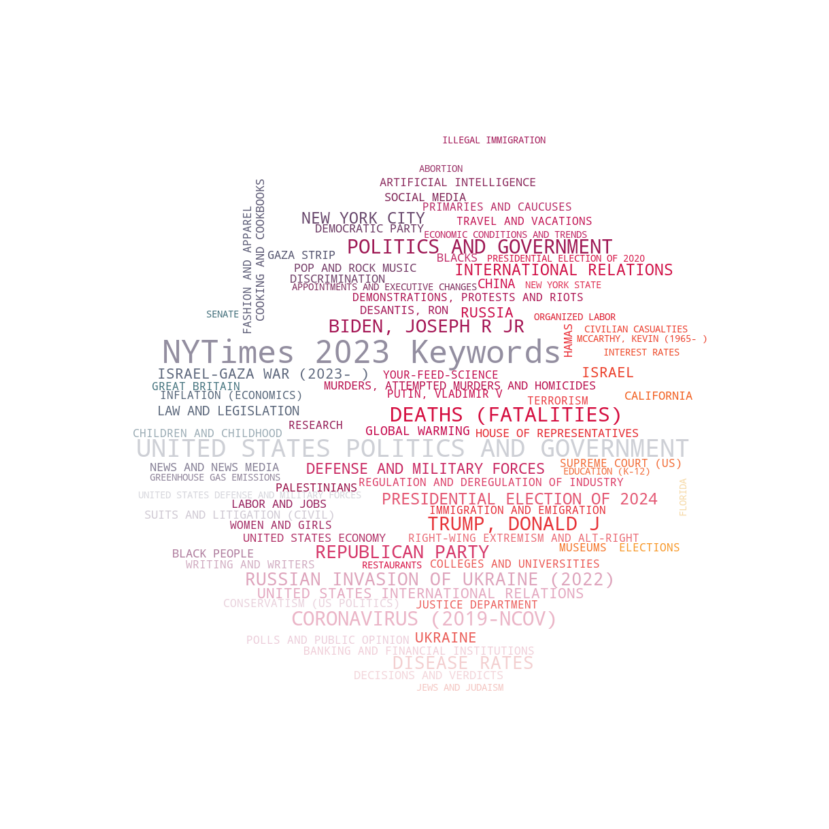

In [185]:
wordcloud = WordCloud(width=500, height=500, background_color="rgba(255, 255, 255, 0)", mask=mask,
                      color_func=image_colors).generate_from_frequencies(top_100_dict)
plt.figure(figsize=(15,15), facecolor='w')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")

In [186]:
wordcloud.to_file('NYTimes_keywords_2023.png')